In [2]:
# CELL 1: Importing packages and telling it where I am (so I don't have to change directories all the time)
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.stats import mad_std
from astropy.time import Time
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils import aperture_photometry,CircularAperture,CircularAnnulus,IRAFStarFinder,SkyCircularAperture,DAOStarFinder

location = raw_input('Location: ')
if 'campus' in location:
    basedir = '/mnt/amw58-XDrive/Physics/ResearchProjects/VScowcroft/MPhys/MW_Mass/Sgr_Stream_Output/'
    sheetname = '/u/m/amw58/dos/MPHYS_PROJECT/megasheet.csv'
elif 'home' in location:
    basedir = 'D:/Mark/Documents/UniWork/milky_way/Sgr_Stream_Output/'
    sheetname = 'D:/Mark/Documents/UniWork/milky_way/megasheet.csv'
else:
    print 'Location must be either home or campus'

Location: home


In [25]:
# CELL 2: Choose a star, pull out important information from the megasheet, calculate absolute mag and error

RR = int(input('Enter the number of the star: '))
index = RR-1
sheet = np.genfromtxt(sheetname,skip_header=1,delimiter=',',dtype=None,unpack=True,encoding=None)
RA = sheet[index][9];dec = sheet[index][11]
CSSno = sheet[index][1]
P = sheet[index][20]; drake_d = sheet[index][21]; A_v = sheet[index][22]

print 'CSS identifier: {0}'.format(CSSno)
print 'Period: {0} days'.format(P)
print 'Distance (Drake): {0} kpc'.format(drake_d)
print 'V-band extinction: {0} mag'.format(A_v)

# a and b from Neeley et al. 2018
# sigma-P assumed to be 0.002% (from skimming Drake paper, will read more thoroughly later) 
a = -0.44; aerr = 0.02
b = -3.58; berr = 0.33
M = a+b*(np.log10(P)+0.27)
Merr2 = (aerr)**2+((berr**2)*(np.log10(P)+0.27)**2)+(0.00002*b/np.log(10))**2

print 'Absolute magnitude (calculated from period): {0} ± {1}'.format(M,np.sqrt(Merr2))

Enter the number of the star: 67
CSS identifier: CSS_J114234_2262655
Period: 0.66741 days
Distance (Drake): 15.61 kpc
V-band extinction: 0.041 mag
Absolute magnitude (calculated from period): -0.777925900115 ± 0.0370175388472


72.8978881836
72.9136657715
72.9490203857
72.9158172607
72.878868103
72.9287719727
72.8012237549
72.8266601562
72.8433609009
72.9583511353
72.9114227295
72.8663024902


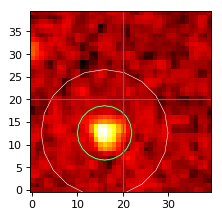

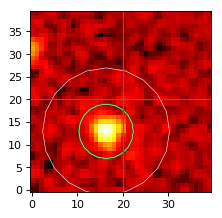

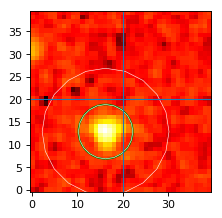

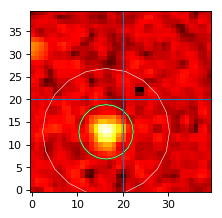

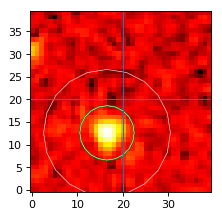

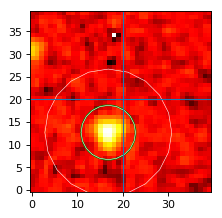

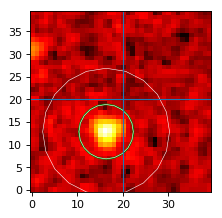

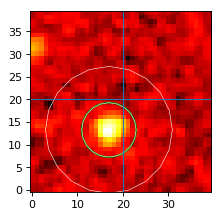

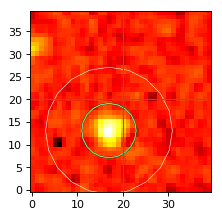

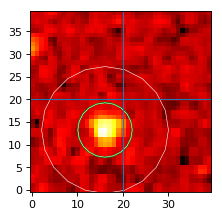

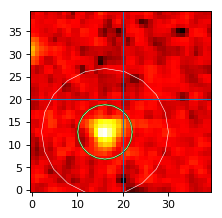

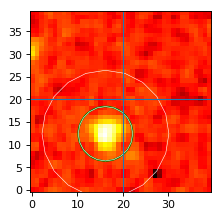

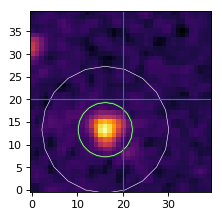

In [30]:
# CELL 3: Aperture Photometry

detection_w = 5.
aperture_r = 6.
r_in = 6.
r_out = 14.
region_r = 20
tol = 30.
LC = []

# list of exceptions to the usual 12 epochs
if RR==43:
    nepochs = 25
elif RR==22:
    nepochs = 18
elif RR==59:
    nepochs = 9
elif RR==90:
    nepochs = 11
else:
    nepochs = 12

for i in range(nepochs):
    epoch=str(i+1)
    CSSep = CSSno + '__e' + epoch
    filename = basedir + CSSep + '/' + CSSep + '_3p6um.fits'
    fitsimg = fits.open(filename)
    header = fitsimg[0].header
    conv = 1/header['FLUXCONV']   # conversion from Spitzer flux to counts
    data = fitsimg[0].data*conv

    sources,region = starfinder(header,data,tol)
    phase,counts,countserr,apertures,annuli,anerr,aperr,poiserr = ap_phot(sources)
    LC.append([phase,counts,countserr])
    fitsplot(region,'hot')
    
    print header['EXPTIME']
    
mosaic_file = basedir + 'MegaMosaics/' + CSSno + '/' + CSSno + '_3p6um.fits'
fitsimg = fits.open(mosaic_file)
header = fitsimg[0].header
conv = 1/header['FLUXCONV']   # conversion from Spitzer flux to counts
data = fitsimg[0].data*conv

sources,region = starfinder(header,data,tol)
bigphase,bigcounts,bigcountserr,apertures,annuli,anerr,aperr,poiserr = ap_phot(sources)
fitsplot(region,'inferno')

Calculated flux: 18.8844735756 MJy/sr
Calculated apparent magnitude: 15.6124865547 ± 0.103388961771
Calculated distance: 18970.6622039 pc, relative error 5.05721825032%
Out by a factor of 1.21528905855


Text(0,0.5,'Apparent magnitude [3.6um]')

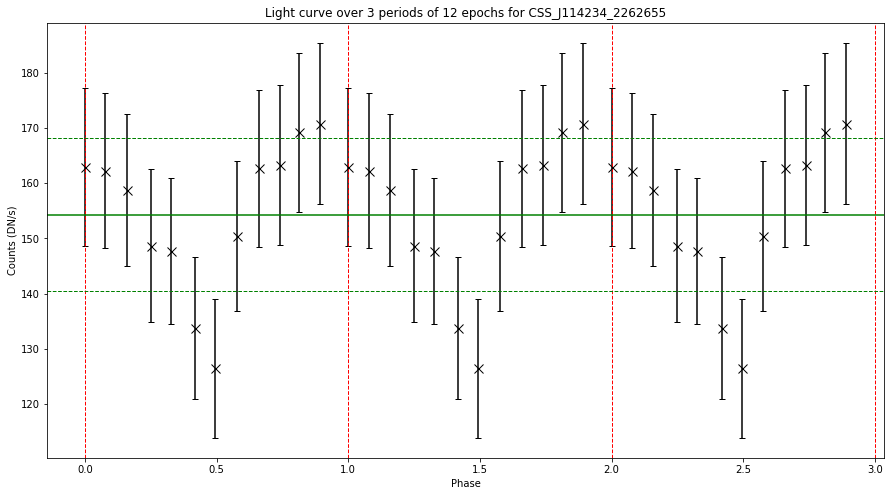

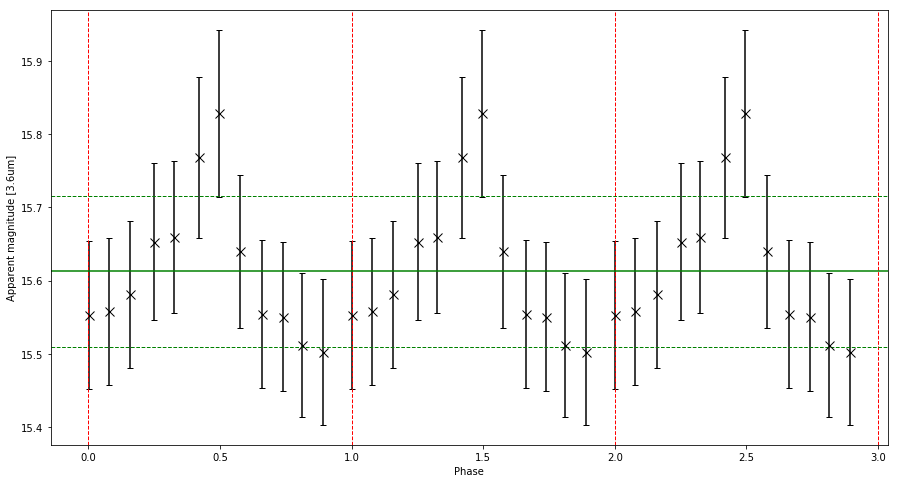

In [31]:
def func(x):
    return (-2.5/np.log(10))/x

k = 0.1088; kerr = 0.0022
f_ap = 1.125; f_aperr = 0.02*f_ap   # aperture correction for 3,3,7 aperture and annulus (IRAC handbook)
F0 = 280.9; F0err = 4.1   # zero-mag flux for 3.6um band
s_ang = (0.6*np.pi/(180*3600))**2   # solid angle in sr of a single pixel (0.6 arcseconds, squared)

m = -2.5*np.log10(f_ap*k*bigcounts*s_ang*1000000/(F0))
merr = np.sqrt(((F0err**2)*func(F0)**2)+((bigcountserr**2)*func(bigcounts)**2)+((kerr**2)*func(k)**2)+((f_aperr**2)*func(f_ap)**2))
muerr2 = Merr2+merr**2
d = 10**((m-M+5.)/5.)
derr = np.sqrt(muerr2*(d*np.log(10)/5)**2)
flux = bigcounts*k*f_ap
print 'Calculated flux: {0} MJy/sr'.format(flux)
print 'Calculated apparent magnitude: {0} ± {1}'.format(m,merr)
print 'Calculated distance: {0} pc, relative error {1}%'.format(d,(100*derr/d))
print 'Out by a factor of {0}'.format(d/(drake_d*1000))

LC.sort()
phases = []
counts = []
errors = []
nperiods = 3
for i in range(nepochs*nperiods):
    phases.append(LC[np.mod(i,nepochs)][0]+np.floor(i/nepochs))
    counts.append(LC[np.mod(i,nepochs)][1])
    errors.append(LC[np.mod(i,nepochs)][2])
magnitudes = np.zeros(len(counts))
magerrors = np.zeros(len(counts))
for i in range(len(counts)):
    magnitudes[i] = -2.5*np.log10(f_ap*k*counts[i]*s_ang*1000000/(F0))
    magerrors[i] = np.sqrt(((F0err**2)*func(F0)**2)+(((errors[i])**2)*func(counts[i])**2)+((kerr**2)*func(k)**2)+((f_aperr**2)*func(f_ap)**2))
    
graphtitle = 'Light curve over {0} periods of {1} epochs for {2}'.format(nperiods,nepochs,CSSno)
plt.figure(figsize=(15,8))
plt.title(graphtitle)
plt.errorbar(phases,counts,yerr=errors, fmt='x',color='black',capsize=3,markersize=9)
for i in range(nperiods+1):
    plt.axvline(i,color='r',linestyle='--',lw=1)
plt.axhline(bigcounts,color='green')
plt.axhline(bigcounts+bigcountserr,color='green',linestyle='--',lw=1)
plt.axhline(bigcounts-bigcountserr,color='green',linestyle='--',lw=1)
plt.xlabel('Phase')
plt.ylabel('Counts (DN/s)')

plt.figure(figsize=(15,8))
plt.errorbar(phases,magnitudes,yerr=magerrors, fmt='x',color='black',capsize=3,markersize=9)
for i in range(nperiods+1):
    plt.axvline(i,color='r',linestyle='--',lw=1)
plt.axhline(m,color='green')
plt.axhline(m+merr,color='green',linestyle='--',lw=1)
plt.axhline(m-merr,color='green',linestyle='--',lw=1)
plt.xlabel('Phase')
plt.ylabel('Apparent magnitude [3.6um]')

In [5]:
def starfinder(header,data,tolerance):    
    th = header['CROTA2']*np.pi/180
    d_RA = RA - header['CRVAL1']
    d_dec = dec - header['CRVAL2']
    dX = -(d_RA*np.cos(th) + d_dec*np.sin(th))*6000
    dY = -(d_RA*np.sin(th) - d_dec*np.cos(th))*6000   
    Xstar = int(np.floor(dX + header['CRPIX1']))
    Ystar = int(np.floor(dY + header['CRPIX2']))
    region = data[Ystar-region_r:Ystar+region_r,Xstar-region_r:Xstar+region_r]
    
    bkg_sigma = mad_std(region,ignore_nan=True)
    bkg_median = np.nanmedian(region)
    starfind = IRAFStarFinder(fwhm=detection_w,threshold=tolerance*bkg_sigma,exclude_border=False,sharplo=0,roundhi=10,minsep_fwhm=0.)
    sources = starfind(region-bkg_median)
    
    return sources,region

def ap_phot(sources):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=aperture_r)
    annuli = CircularAnnulus(positions,r_in=r_in,r_out=r_out)
    totals = [apertures,annuli]
    phot_table = aperture_photometry(region, totals)
    Non = apertures.area()
    Nsky = annuli.area()
    
    bkg_mean = (phot_table['aperture_sum_1'])/annuli.area()
    bkg_sum = bkg_mean*apertures.area()
    final_sum = phot_table['aperture_sum_0']-bkg_sum
    phot_table['final_sum']=final_sum
    phot_table['weightedcounts'] = phot_table['final_sum']/np.sqrt((phot_table['xcenter']-region_r*u.pix)**2+(phot_table['ycenter']-region_r*u.pix)**2)
    counts = phot_table[phot_table['weightedcounts'].argmax()]['final_sum']
    MJD = Time(header['DATE_OBS'], format='isot',scale='utc').jd -2400000.5
    phase = MJD/P - np.floor(MJD/P)
    anerr = bkg_mean*Non/np.sqrt(Nsky)
    aperr = bkg_mean*np.sqrt(Non)
    poissonerr = np.sqrt(final_sum)
    countserrs = np.sqrt(anerr**2+aperr**2+poissonerr**2) 
    phot_table['err'] = countserrs
    countserr = phot_table[phot_table['weightedcounts'].argmax()]['err']
    return phase,counts,countserr,apertures,annuli,anerr,aperr,poissonerr

def fitsplot(region,cmap):
    plt.figure(figsize=(3,3),dpi=80)
    plt.imshow(region,cmap=cmap,origin='left',aspect='equal',norm=LogNorm())
    plt.axvline(region_r,lw=1);plt.axhline(region_r,lw=1)
    apertures.plot(color='green',lw=1.5,alpha=1)
    annuli.plot(color='white',lw=.5,alpha=1)